# Notebook for inference using WebUI + ControlNet API. 
### Inference parameters for videos 52_56

In [1]:
import requests
import cv2
from PIL import Image
from base64 import b64encode
import os
import base64
from tqdm import tqdm
import matplotlib.pyplot as plt
import io
import numpy as np
import torchvision.transforms as transforms
import random
import glob
import shutil

In [ ]:
##############################   FILL HERE AND PARAMS IN PAYLOAD   #############################
############### THESE PART REQUIRES SOME CHECKING AND CAREFUL CODE FOLLOWING ##################

url = "http://127.0.0.1:7860"


inputs_dir = 'path/to/inputs'
output_dir = 'output/path'
textured_dir = 'path/to/textured_inputs_52_56'
outpaint = True # we want it to have 512x512 images padded with black areas at the top and bottom

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)


#list source filenames based on textured images
random.seed(420420)
source_imgs = random.sample(os.listdir(textured_dir),10000)

print('N IMAGES TO GENERATE: ', len(source_imgs))


In [2]:
t = transforms.CenterCrop((int(256/456*512), 512))

for source_img in tqdm(source_imgs):

    inp = cv2.imread(inputs_dir + '/' +source_img)
    tex = cv2.imread(textured_dir + '/' +source_img) 

    if outpaint:
        height_margin = (max(inp.shape[:2]) - inp.shape[0])/2
        width_margin = (max(inp.shape[:2]) - inp.shape[1])/2
        add_height, add_width = int(max(0, height_margin)), int(max(0, width_margin))

        inp = cv2.copyMakeBorder(inp, add_height, add_height, add_width, add_width, cv2.BORDER_CONSTANT, value =(0,0,0))
        inp = cv2.resize(inp, (512, 512), cv2.INTER_NEAREST )

        tex = cv2.copyMakeBorder(tex, add_height, add_height, add_width, add_width, cv2.BORDER_CONSTANT, value = (0,0,0))
        tex = cv2.resize(tex, (512, 512), cv2.INTER_NEAREST )
       
    retval, inp = cv2.imencode('.jpg', inp)
    inp = base64.b64encode(inp).decode('utf-8')

    retval, tex= cv2.imencode('.jpg', tex)
    tex = base64.b64encode(tex).decode('utf-8')

    
    payload = {
    #"resize_mode": 1,
    "init_images": [tex],
    "denoising_strength": 0.45,
    "prompt": "cholect45",
    "sampler_name": "DPM++ 2M Karras",
    "width":512,
    "height":512,
    "steps": 20,
    "cfg_scale":4.5,
    "negative_prompt": "",
    "include_init_images": True,
    "batch_size":1,
    "alwayson_scripts": {
      "controlnet": {
        ###  instances in args list below should be equal to max controlnet number defined in webui Settings.
        "args": [
          {
            "model":"control_v11p_sd15_softedge [a8575a2a]",
            "enabled":True,
	          "input_image":inp,
            "module": "softedge_pidisafe",
            "weight": 0.50,
            "processor_res":512,
            "guidance_end": 1,
            "control_mode":0,

          },

          {
            "model": "control_v11f1e_sd15_tile [a371b31b]",
            "enabled":True,
	          "input_image":tex,
            "module": "tile_resample",
            "weight":0.3,
            "processor_res": 512,
            "threshold_a": 1.25,
            "control_mode":0,

          }
        ]
    }
    }
    }

    response = requests.post(url=f'{url}/sdapi/v1/img2img', json=payload)
    r = response.json()
    output = Image.open(io.BytesIO(base64.b64decode(r['images'][0].split(",",1)[0])))
    if outpaint:
      output = t(output)
    output.save(output_dir+'/'+source_img)




N IMAGES TO GENERATE:  10000


100%|██████████| 10000/10000 [7:47:51<00:00,  2.81s/it]    


Text(0.5, 1.0, 'textured')

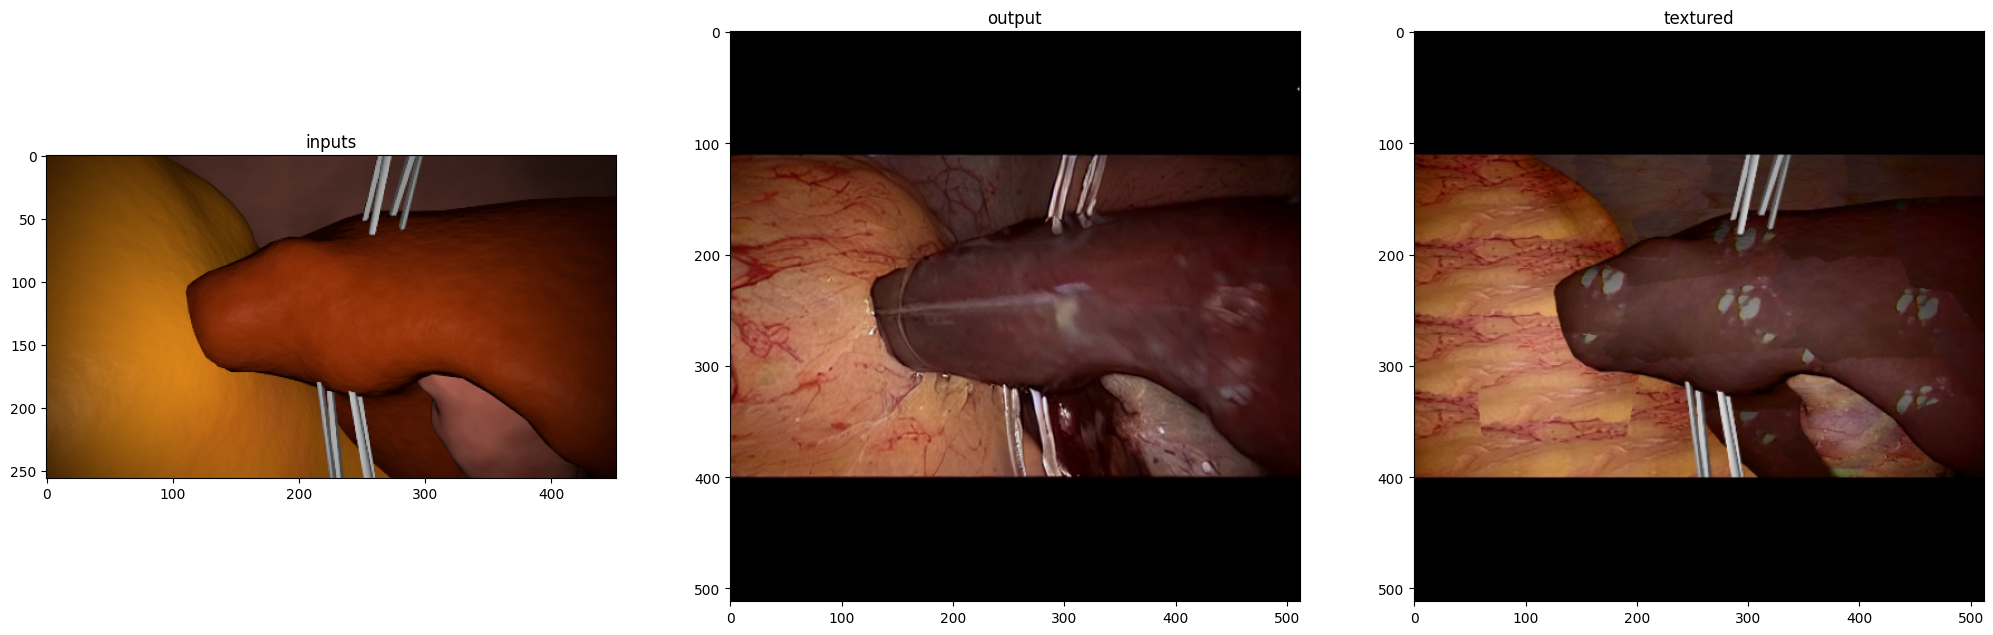

In [3]:
f, ax = plt.subplots(1, 3, figsize=(25, 10))
input = Image.open(os.path.join(inputs_dir, source_img))
ax[0].imshow(input)
ax[0].set_title('inputs')

output = Image.open(io.BytesIO(base64.b64decode(r['images'][0].split(",",1)[0])))
ax[1].imshow(output)
ax[1].set_title('output')

input = Image.open(io.BytesIO(base64.b64decode(tex)))
ax[2].imshow(input)
ax[2].set_title('textured')

Text(0.5, 1.0, '2. controlnet - control input')

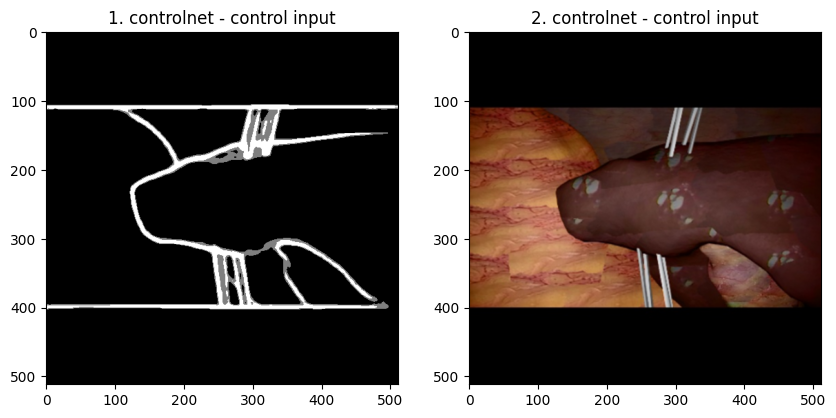

In [4]:
# auxiliary plot to check preprocessor output. Change 1 in r['images'][1] to other value depending on preprocessor number you want to check
# detect maps may be switched off in UI setting for performance purposes

f, ax = plt.subplots(1, 2, figsize=(10, 5))
output = Image.open(io.BytesIO(base64.b64decode(r['images'][1].split(",",1)[0])))
ax[0].imshow(output)
ax[0].set_title('1. controlnet - control input')

output = Image.open(io.BytesIO(base64.b64decode(r['images'][2].split(",",1)[0])))
ax[1].imshow(output)
ax[1].set_title('2. controlnet - control input')
